In [1]:
# Load required libraries

In [2]:
pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3549 sha256=45d43946d4828be80413d32d2265d7c2f1c31856e386255b7f605f86d0d72e12
  Stored in directory: c:\users\ajay\appdata\local\pip\cache\wheels\82\d8\73\e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyLDAvis


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -- ------------------------------------- 0.2/2.6 MB 1.9 MB/s eta 0:00:02
   ------------- -------------------------- 0.9/2.6 MB 7.0 MB/s eta 0:00:01
   ---------------------------- ----------- 1.9/2.6 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/59.6 kB ? eta -:--:--
   ---------------------------------------- 59.6/59.6 kB 3.1 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20451 sha256=58731c937a43c1bf3317bc4af33c66da12ba644

In [5]:
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from nltk import sent_tokenize, word_tokenize
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
     
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AJAY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AJAY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
input_data = pd.read_csv('dataset.csv')

In [7]:
input_data.head()

,Review,Recommend
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [8]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Recommend  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [9]:
input_data.shape

(23486, 2)

In [12]:
input_data['Recommend'].value_counts() 

Recommend
1    19314
0     4172
Name: count, dtype: int64

In [14]:
#As we can see there are around 23K+ reviews in the dataset. Each review has a corresponding recommendation value and there are more recommended products compared to non-recommended

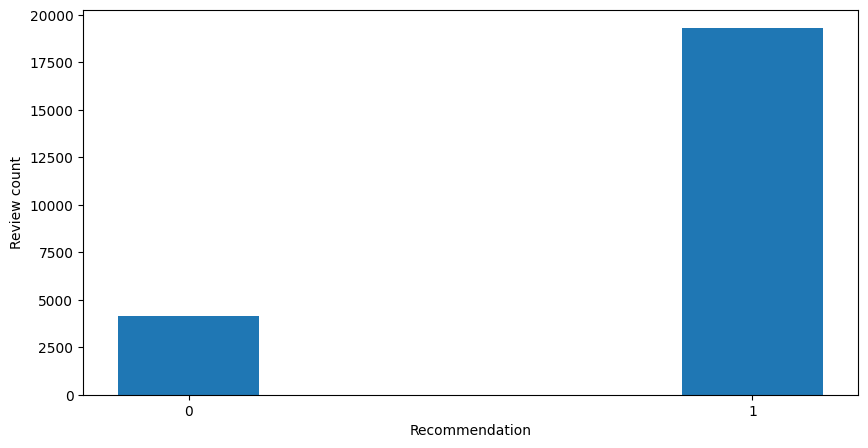

In [16]:
label_dist = input_data['Recommend'].value_counts().to_dict() 
flag = plt.figure(figsize = (10, 5)) 
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25) 
plt.xticks([0,1]) 
plt.xlabel('Recommendation') 
plt.ylabel('Review count') 
plt.show() 

In [18]:
print(input_data.isnull().sum())

Review       845
Recommend      0
dtype: int64


In [25]:
input_data['Review'].fillna("No review provided", inplace=True)

In [26]:
input_data.isnull().sum()

Review       0
Recommend    0
dtype: int64

In [27]:
input_data.dtypes

Review       object
Recommend     int64
dtype: object

In [28]:
len(input_data['Review'])-len(input_data['Review'].drop_duplicates())

851

In [29]:
iput_data = input_data.drop_duplicates(subset='Review', keep='last')
input_data.shape

(23486, 2)

In [30]:
input_data['length'] = input_data['Review'].apply(lambda x:len(x.split(' '))) 

In [31]:
input_data.sample(10) 

,Review,Recommend,length
3315,I bought this online with the intention of it ...,0,94
5641,This dress is perfect for wearing in autumn (a...,1,95
5165,No review provided,0,3
11143,Beautiful and stylish. looks amazing with my n...,1,42
13684,I had high hopes for this top but it didn't wo...,0,39
11159,Highly recommend these jeans! they are ultra-s...,1,59
11604,"I read the previous reviews, but decided to tr...",1,33
4324,I originally bought this dress in navy and i a...,1,100
784,"I loved this in the store, but had to order my...",1,79
1197,"This is one of those dresses that is just ""nic...",1,85


In [33]:
print(round(input_data[input_data['Recommend']== 1 ]['length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['length'].mean()))

58
61


In [34]:
#revmoving the stopwords

input_data['Review_new']=input_data['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [35]:
def text_clean(review):
    review = review.lower()
     #remove punctuation 
    review = re.sub('[()!?]', ' ', review)
    review = re.sub('\[.*?\]',' ', review)
    #remove non alphanumeric occurences
    review = re.sub("[^a-z0-9]"," ", review)
    #remove the @mention
    review = re.sub("@[A-Za-z0-9_]+","", review)
    #remove the hastags
    review = re.sub("#[A-Za-z0-9_]+","", review)
    #remove any links 
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r"www.\S+", "", review)
    return review

In [39]:
input_data['clean_review'] = input_data['Review_new'].apply(text_clean)

In [40]:
input_data[['Review','clean_review']].sample(10)

,Review,clean_review
9035,"Lovely top, flattering and dressy, would defin...",lovely top flattering dressy would definitel...
12063,"I love this dress. it is beautiful , feminine...",i love dress beautiful feminine fits perfe...
20833,"You can't exactly tell from the picture, but t...",you can t exactly tell picture dress skirt bu...
14004,Purchased for myself and loved the fabric and ...,purchased loved fabric unique design runs lar...
7433,I ordered this in xl and the fit on me matches...,i ordered xl fit matches fit model meant loos...
3662,Such an amazing shirt to dress down for a long...,such amazing shirt dress long day school
7328,I love the idea of this top. it's made really ...,i love idea top made really well issue bit s...
22723,Saw this in the store and loved it! the photos...,saw store loved it photos line justice mater...
571,No review provided,no review provided
11722,The fit is so bad and the construction is very...,the fit bad construction poor i m 5 1 100 ...


In [41]:
input_data['new_length']=input_data['clean_review'].apply(lambda x:len(x.split(" ")))

In [43]:
print(round(input_data[input_data['Recommend']==1]['new_length'].mean())) 
print(round(input_data[input_data['Recommend']==0]['new_length'].mean())) 

39
40


In [44]:
X_train, X_test, y_train, y_test = train_test_split(input_data['clean_review'],
                                                    input_data['Recommend'], test_size=0.3,
                                                    stratify=input_data['Recommend']) 

In [47]:
print(X_train.shape[0], X_test.shape[0]) 

16440 7046


In [49]:
print(y_train.value_counts()) 

Recommend
1    13520
0     2920
Name: count, dtype: int64


In [50]:
print(y_test.value_counts()) 

Recommend
1    5794
0    1252
Name: count, dtype: int64


In [51]:
#Ml modeling adn performance evalution

In [58]:
modelclasses = [
    ["Logistic Regression", LogisticRegression],
    ["MNB", MultinomialNB],
    ["Random Forest", RandomForestClassifier]]

In [60]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create an empty list to store results
results = []

for modelname, Model in modelclasses:
  model = Model()
  model.fit(X_train_vec, y_train)
  score = np.round(model.score(X_test_vec, y_test), 2)
  auc = np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]), 2)
  # Append results to the list
  results.append({'modelname': modelname, 'score': score, 'auc': auc})

# Convert the list to a DataFrame
results_df = pd.DataFrame(results)

In [61]:
print(results_df)

             modelname  score   auc
0  Logistic Regression   0.89  0.91
1                  MNB   0.89  0.92
2        Random Forest   0.85  0.90


In [62]:
#use the tf-idf vectorizer to convert the text data to numerical from 

In [65]:
vectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['modelname', 'score', 'auc'])

for modelname, Model in modelclasses:
  model = Model()
  model.fit(X_train_vec, y_train)
  score = np.round(model.score(X_test_vec, y_test), 2)
  auc = np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]), 2)
  # Create a temporary DataFrame for each iteration
  temp_df = pd.DataFrame({'modelname': [modelname], 'score': [score], 'auc': [auc]})
  # Concatenate the temporary DataFrame to the results DataFrame
  results = pd.concat([results, temp_df], ignore_index=True)

# Print or use the results DataFrame
print(results)

             modelname  score   auc
0  Logistic Regression   0.88  0.93
1                  MNB   0.83  0.90
2        Random Forest   0.85  0.90


In [66]:
#Tapic Modeling

In [69]:
def topic_clean(review):
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r's+', ' ', review)
    return review

In [70]:
input_data['clean_review'] = input_data['clean_review'].apply(topic_clean)

In [73]:
review_terms = pd.Series(input_data['clean_review']).apply(lambda x: x.split())

In [74]:
dictionary = corpora.Dictionary(review_terms) 

In [75]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in review_terms]

In [76]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, 
                chunksize=500,
                passes=10)

In [77]:
lda_model.print_topics()

[(0,
  '0.054*"ize" + 0.046*"i" + 0.031*"fit" + 0.031*"mall" + 0.029*"m" + 0.021*"u" + 0.018*"ordered" + 0.017*"t" + 0.016*"large" + 0.016*"run"'),
 (1,
  '0.029*"t" + 0.023*"dre" + 0.019*"like" + 0.018*"top" + 0.018*"look" + 0.017*"i" + 0.016*"fabric" + 0.011*"o" + 0.011*"would" + 0.011*"back"'),
 (2,
  '0.041*"i" + 0.025*"it" + 0.025*"tore" + 0.018*"online" + 0.016*"tried" + 0.015*"one" + 0.015*"aw" + 0.014*"price" + 0.014*"ale" + 0.012*"on"'),
 (3,
  '0.040*"e" + 0.029*"love" + 0.025*"jean" + 0.023*"top" + 0.023*"great" + 0.023*"pant" + 0.022*"hirt" + 0.020*"color" + 0.019*"fit" + 0.017*"i"'),
 (4,
  '0.051*"weater" + 0.050*"h" + 0.036*"color" + 0.033*"wa" + 0.023*"wi" + 0.021*"leeve" + 0.016*"oft" + 0.014*"hed" + 0.013*"grey" + 0.012*"like"'),
 (5,
  '0.118*"on" + 0.067*"per" + 0.024*"color" + 0.019*"much" + 0.015*"online" + 0.014*"blue" + 0.013*"rea" + 0.013*"better" + 0.012*"ub" + 0.012*"even"'),
 (6,
  '0.223*"review" + 0.098*"no" + 0.088*"provided" + 0.051*"cardigan" + 0.035*"o

In [78]:
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)     
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.184180  0.002554       1        1  27.421683
0     -0.185875 -0.070406       2        1  20.823385
9     -0.190005  0.016206       3        1  13.605128
3     -0.199760  0.035149       4        1  11.832670
2     -0.084189 -0.077696       5        1  10.064641
4     -0.073686  0.175152       6        1   6.298533
8      0.102758 -0.291020       7        1   3.713833
5      0.168449  0.249271       8        1   3.041221
7      0.307002 -0.156251       9        1   1.852736
6      0.339486  0.117041      10        1   1.346170, topic_info=          Term          Freq         Total Category  logprob  loglift
162          t  12136.000000  12136.000000  Default  30.0000  30.0000
51         ize   9524.000000   9524.000000  Default  29.0000  29.0000
155         on   3783.000000   3783.000000  Default  28.0000  28.0000
264     review   2295.000000   2295.000000  Default  27.0000  27.0000
9          dre  12530.000000  12530.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1473  detailed     57.276397     58.193861  Topic10  -5.1926   4.2920
1405       fre     55.856003     56.773533  Topic10  -5.2177   4.2916
1307       fur     55.188837     56.106316  Topic10  -5.2297   4.2914
3385  charming     49.621858     50.539469  Topic10  -5.3360   4.2896
494         he    214.706662    319.915331  Topic10  -3.8712   3.9091

[590 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         9  0.999181      ab
1000      1  0.994508      ad
88        1  0.997279    adju
416       1  0.998571    adly
2169      9  0.995795   adore
...     ...       ...     ...
237       7  0.998258    year
1471      4  0.473719  yellow
1471      8  0.522595  yellow
73        1  0.997161     zip
74        1  0.997260  zipper

[959 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 10, 4, 3, 5, 9, 6, 8, 7])